# mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls drive

MyDrive


In [3]:
cd /content/drive/MyDrive/Colab Notebooks/recommendation_systems

/content/drive/MyDrive/Colab Notebooks/recommendation_systems


In [4]:
! ls

amazon_review.ipynb	mind_news_recommend_data_process.ipynb
avito.ipynb		mind_news_recommend_distilbert.ipynb
knowledge_distillation	mind_news_recommend_doc2vec.ipynb
livedoor_doc2vec.ipynb	mind_news_recommend_knowledge_distillation.ipynb
mind_dataset


# import modules

In [5]:
import os
import re
from glob import glob
import zipfile
import pickle
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

from wordcloud import WordCloud

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

# download data

https://msnews.github.io/

# load data

In [6]:
total_set = 4
data_path = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/"
# data_path = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/"

In [7]:
# The behaviors.tsv file contains the impression logs and users' news click histories. 
# It has 5 columns divided by the tab symbol:
# - Impression ID. The ID of an impression.
# - User ID. The anonymous ID of a user.
# - Time. The impression time with format "MM/DD/YYYY HH:MM:SS AM/PM".
# - History. The news click history (ID list of clicked news) of this user before this impression.
# - Impressions. List of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click).
behaviors_path = os.path.join(data_path, 'behaviors.tsv')
df_behaviors = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])
df_behaviors.head()

,impression_id,user_id,time,history,impressions
0,1,U87243,11/10/2019 11:30:54 AM,N8668 N39081 N65259 N79529 N73408 N43615 N29379 N32031 N110232 N101921 N12614 N129591 N105760 N60457 N1229 N64932,N78206-0 N26368-0 N7578-0 N58592-0 N19858-0 N58258-0 N18478-0 N2591-0 N97778-0 N32954-0 N94157-1 N39404-0 N108809-0 N78699-1 N71090-1 N40282-0 N31174-1 N37924-0 N27822-0
1,2,U598644,11/12/2019 1:45:29 PM,N56056 N8726 N70353 N67998 N83823 N111108 N107520 N53168 N78756 N106411 N81824 N85691 N16173 N24446 N120926 N19175 N126159 N26373 N72369 N73228 N111873 N88638 N29503 N31055,N47996-0 N82719-0 N117066-0 N8491-0 N123784-0 N21431-0 N106162-0 N59646-0 N118348-0 N25587-1 N37544-0 N20780-0 N36266-1 N46329-0 N64102-0 N120930-0 N62024-0 N11017-0 N76539-0 N26359-0 N108379-0 N87913-0 N125161-0 N23946-0 N83702-0 N62788-0 N6306-0 N66902-0 N93643-0
2,3,U532401,11/13/2019 11:23:03 AM,N128643 N87446 N122948 N9375 N82348 N129412 N54948 N36094 N44660 N3948 N21332 N81364 N83062 N87788 N59280 N31323,N103852-0 N53474-0 N127836-0 N47925-1
3,4,U593596,11/12/2019 12:24:09 PM,N31043 N39592 N4104 N8223 N114581 N92747 N12070 N61321 N40052 N50176 N101119 N76810 N37509,N38902-0 N76434-0 N71593-0 N100073-0 N108736-0 N3061-0 N89658-0 N33030-0 N110473-0 N125655-0 N100206-0 N37544-0 N60370-0 N59935-0 N114935-1 N114135-0 N46262-0 N61065-0 N46329-0 N27368-0 N84381-0 N83412-0 N2624-0 N34269-0 N19053-0 N115724-0 N20990-0 N100380-0 N2074-0 N128367-0 N8719-0 N109344-0 N33078-0 N100539-0 N119665-0 N7937-0 N121580-0 N108581-0 N92498-0 N18947-0 N109642-0 N79048-0 N47277-0 N53225-0 N41710-0 N122819-0 N30417-0 N79044-0 N76539-0 N57763-0 N54239-0 N62203-0
4,5,U239687,11/14/2019 8:03:01 PM,N65250 N122359 N71723 N53796 N41663 N41484 N112765 N100765 N87642 N83576 N33881 N110863 N67875 N100466 N36761 N116312 N82374 N93136 N10659 N4857 N32369 N21104 N96120 N50191 N77001 N59349 N66535 N19719 N127567 N96764 N54850 N61319 N113547 N13277 N36604 N32800 N116279 N73179 N124109 N16608 N98215 N6229 N17492 N64552 N91231 N63676 N67779 N82799 N9375 N26586 N48453 N10711 N101263 N21773 N115066 N70097 N18031 N15471 N454 N56610 N112933 N75756 N72571 N41544 N48112 N42209 N44759 N76970 N69300 N108284 N76557 N104961 N46069 N81745 N117275 N12252 N116750 N18171 N87002 N60556 N45946 N20573 N6718 N50901 N3290 N10869 N40259 N14986 N97548 N51302 N39307 N86320 N89086 N29786 N37094 N38627 N51450 N107878 N126611 N57342 N81982 N87654 N3435 N83253 N123097 N113417 N71728 N100119 N57900 N7391 N13604 N71728 N111704 N3565 N53215 N39384 N44431 N129207 N31418 N32534 N124532 N15922 N118298 N19577 N34004 N104234 N103357 N7992 N87859 N80126 N86141 N4289 N127530 N36450 N91985 N9273 N105191 N2927 N49485 N34520 N129412 N75078 N97753 N88892 N79285 N115007 N68429 N56365 N60132 N91985 N79724 N32641 N29709 N36823 N96616 N29709 N46994 N128125 N100655 N18914 N43911 N119601 N43312 N4012 N102366 N92079 N71665 N54177 N43104 N21264 N44671 N98656 N108393 N94450 N75220 N101271 N59645 N55120 N128115 N262 N117511 N70198 N88893 N9892 N9035 N102952 N117229 N65740 N72408 N117791 N80178 N477 N38485 N104029 N93006 N121168 N29466 N64862 N36573 N61712 N49594 N94499 N66959 N11266 N71922 N114335 N24344 N45083 N90679 N100033 N128429 N72135 N3113 N25166 N89408 N106403 N23264 N5967 N12820 N31820 N93575 N51431 N53933 N121845 N25163 N82045 N10996 N104737 N86842 N52677 N50720 N71857 N1118 N71977 N65749 N124752 N18515 N55558 N93359 N72976 N30755 N98095 N89631 N124966 N59447 N65044 N2664 N23666 N98051 N18548 N24446 N113698 N91597 N61321 N29936 N16202 N3188 N108312 N48258 N4266 N91979 N33197 N107039 N70664 N92747 N14032 N74723 N97466 N82926 N3242 N49418 N22773 N110586 N149 N76018 N39270 N34431 N59033 N26572 N78741 N10705 N13901 N89509 N5326 N94706 N77135 N46477 N5653 N114343 N64300 N48084 N91968 N13434 N73137 N1886 N90966 N18904 N1713 N40765 N120031 N21641 N67466 N35667 N10490 N112667 N108016 N41056 N67497 N120196 N50684 N11952 N41214 N31494 N64035 N70868 N73183 N81315 N78570 N88019 N54753 N75342 N73240 N11653 N116736 N127001 N18681 N97815 N51166 N41083 N9

In [8]:
# The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
# It has 7 columns, which are divided by the tab symbol:
# - News ID
# - Category
# - Subcategory
# - Title
# - Abstract
# - URL
# - Title Entities (entities contained in the title of this news)
# - Abstract Entities (entities contained in the abstract of this news)
news_path = os.path.join(data_path, 'news.tsv')
df_news = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])
df_news.head()

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By","Shop the notebooks, jackets, and more that the royals can't live without.",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"", ""Type"": ""P"", ""WikidataId"": ""Q80976"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [48], ""SurfaceForms"": [""Prince Philip""]}, {""Label"": ""Charles, Prince of Wales"", ""Type"": ""P"", ""WikidataId"": ""Q43274"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [28], ""SurfaceForms"": [""Prince Charles""]}, {""Label"": ""Elizabeth II"", ""Type"": ""P"", ""WikidataId"": ""Q9682"", ""Confidence"": 0.97, ""OccurrenceOffsets"": [11], ""SurfaceForms"": [""Queen Elizabeth""]}]",[]
1,N45436,news,newsscienceandtechnology,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on last year's models.,https://assets.msn.com/labs/mind/AABmf2I.html,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ""Q2796"", ""Confidence"": 0.999, ""OccurrenceOffsets"": [42], ""SurfaceForms"": [""iPads""]}, {""Label"": ""Walmart"", ""Type"": ""O"", ""WikidataId"": ""Q483551"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [0], ""SurfaceForms"": [""Walmart""]}]","[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ""Q2796"", ""Confidence"": 0.999, ""OccurrenceOffsets"": [12], ""SurfaceForms"": [""iPad""]}, {""Label"": ""Apple Inc."", ""Type"": ""O"", ""WikidataId"": ""Q312"", ""Confidence"": 0.999, ""OccurrenceOffsets"": [0], ""SurfaceForms"": [""Apple""]}]"
2,N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding you back and keeping you from shedding that unwanted belly fat for good.,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""WikidataId"": ""Q193583"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [20], ""SurfaceForms"": [""Belly Fat""]}]","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""WikidataId"": ""Q193583"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [97], ""SurfaceForms"": [""belly fat""]}]"
3,N86255,health,medical,Dispose of unwanted prescription drugs during the DEA's Take Back Day,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ""Type"": ""O"", ""WikidataId"": ""Q622899"", ""Confidence"": 0.992, ""OccurrenceOffsets"": [50], ""SurfaceForms"": [""DEA""]}]",[]
4,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches of Ukraine's War,"Lt. Ivan Molchanets peeked over a parapet of sand bags at the front line of the war in Ukraine. Next to him was an empty helmet propped up to trick snipers, already perforated with multiple holes.",https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId"": ""Q212"", ""Confidence"": 0.946, ""OccurrenceOffsets"": [87], ""SurfaceForms"": [""Ukraine""]}]"


In [9]:
# # The entity_embedding.vec file contains the 100-dimensional embeddings
# # of the entities learned from the subgraph by TransE method.
# # The first column is the ID of entity, and the other columns are the embedding vector values.
# entity_embedding_path = os.path.join(data_path, 'entity_embedding.vec')
# entity_embedding = pd.read_table(entity_embedding_path, header=None)
# entity_embedding['vector'] = entity_embedding.iloc[:, 1:101].values.tolist()
# entity_embedding = entity_embedding[[0,
#                                      'vector']].rename(columns={0: "entity"})
# entity_embedding.head(2)

In [10]:
# # The relation_embedding.vec file contains the 100-dimensional embeddings
# # of the relations learned from the subgraph by TransE method.
# # The first column is the ID of relation, and the other columns are the embedding vector values.
# relation_embedding_path = os.path.join(data_path, 'relation_embedding.vec')
# relation_embedding = pd.read_table(relation_embedding_path, header=None)
# relation_embedding['vector'] = relation_embedding.iloc[:,
#                                                        1:101].values.tolist()
# relation_embedding = relation_embedding[[0, 'vector'
#                                          ]].rename(columns={0: "relation"})
# relation_embedding.head(2)

In [11]:
df_behaviors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232748 entries, 0 to 2232747
Data columns (total 5 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   impression_id  int64 
 1   user_id        object
 2   time           object
 3   history        object
 4   impressions    object
dtypes: int64(1), object(4)
memory usage: 85.2+ MB


In [12]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101527 entries, 0 to 101526
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 101527 non-null  object
 1   category           101527 non-null  object
 2   subcategory        101527 non-null  object
 3   title              101527 non-null  object
 4   abstract           96112 non-null   object
 5   url                101527 non-null  object
 6   title_entities     101524 non-null  object
 7   abstract_entities  101521 non-null  object
dtypes: object(8)
memory usage: 6.2+ MB


In [13]:
df_news[df_news["id"]=="N32231"]

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
101177,N32231,sports,football_nfl,"Football: Kennedy with miracle finish, wins CHSFL championship 39-33 in OT over Spellman",Clayton Proctor ran for four TDs and threw for another as Kennedy came from behind to win the Catholic schools Class A football title in OT over Spellman.,https://assets.msn.com/labs/mind/BBWyseg.html,"[{""Label"": ""Association football"", ""Type"": ""C"", ""WikidataId"": ""Q2736"", ""Confidence"": 0.975, ""OccurrenceOffsets"": [0], ""SurfaceForms"": [""Football""]}]","[{""Label"": ""Touchdown"", ""Type"": ""C"", ""WikidataId"": ""Q650807"", ""Confidence"": 0.997, ""OccurrenceOffsets"": [29], ""SurfaceForms"": [""TDs""]}, {""Label"": ""Catholic Church"", ""Type"": ""O"", ""WikidataId"": ""Q9592"", ""Confidence"": 0.989, ""OccurrenceOffsets"": [94], ""SurfaceForms"": [""Catholic""]}, {""Label"": ""Minor League Baseball"", ""Type"": ""O"", ""WikidataId"": ""Q84129"", ""Confidence"": 0.948, ""OccurrenceOffsets"": [111], ""SurfaceForms"": [""Class A""]}]"


# Exploratory Data Analysis (EDA)

## check category

In [14]:
df_news_count = df_news[['category','subcategory']].value_counts()
df_news_count.head()

category  subcategory      
news      newsus               14467
sports    football_nfl         11813
news      newspolitics          5145
weather   weathertopstories     4253
news      newscrime             3676
dtype: int64

In [15]:
category_index = []
for i in df_news_count.index:
    category_index.append(np.array(i))
category_index = np.array(category_index)
# category_index

In [16]:
df = pd.DataFrame(columns=['category','subcategory','values'])
df['category'] = category_index[:,0]
df['subcategory'] = category_index[:,1]
df['values'] = df_news_count.values

In [17]:
px.bar(data_frame=df,x='category',y='values',color='subcategory')

## check word cloud

In [18]:
def generate_word_cloud(text):
    # Generate a WordCloud figure
    wordcloud = WordCloud().generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    plt.show()
    return

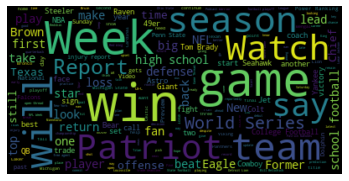

In [19]:
text=' '
for i in df_news[df_news['category']=='sports']['title']:
    text += i+' '

generate_word_cloud(text)

# process data

In [20]:
df_behaviors["impressions"].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [21]:
df_behaviors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232748 entries, 0 to 2232747
Data columns (total 5 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   impression_id  int64 
 1   user_id        object
 2   time           object
 3   history        object
 4   impressions    object
dtypes: int64(1), object(4)
memory usage: 85.2+ MB


In [22]:
# limit data length for processing the data in limited memory
print (len(df_behaviors))
limit_len = int(np.floor(len(df_behaviors)/total_set)*total_set)
df_behaviors = df_behaviors[0:limit_len]
print (len(df_behaviors))

2232748
2232748


In [23]:
# This process uses a lot of memory so I seperate dataset
def process_click(set_num, total_set):
    print ("*"*20, "process:", set_num, total_set)
    df_click = pd.DataFrame([], columns=["impressions","id","click_flag"])
    df_behaviors_len = len(df_behaviors)
    loop_num = int( 10 / total_set)
    interval = int(np.ceil(len(df_behaviors)/loop_num/total_set))
    set_len = int(len(df_behaviors) / total_set)
    print ( df_behaviors_len, interval, loop_num, set_len )
    j = set_len*(set_num-1)
    for i in range(loop_num):
        print (i, j)
        df_impressions = df_behaviors[["impressions"]].iloc[j:j+interval]
        df_click_raw = df_impressions.assign(impressions=df_impressions.impressions.str.split(" ")).explode('impressions')
        df_click_raw[['id','click_flag']] = df_click_raw.impressions.str.split("-", expand=True)
        df_click_raw["click_flag"] = df_click_raw["click_flag"].astype(int)
        df_click = pd.concat([df_click, df_click_raw], ignore_index=True)
        del df_impressions 
        j = j + interval
    display (df_click.info())

    # calculate click probability for each id 
    df_click_group = df_click.groupby("id").apply(lambda x: pd.Series([np.count_nonzero(x["click_flag"]==0),
                                                                    np.count_nonzero(x["click_flag"]==1)],
                                                                    index=["non_click","click"])).reset_index()
    # df_click_group["click_prob"] = df_click_group["click"] / (df_click_group["click"] + df_click_group["non_click"])  
    display (df_click_group.info())

    # save click_prob dataframe
    filename = data_path + "df_click_{}.pkl".format(set_num)
    df_click_group.to_pickle(filename)

    # delete dataframe to free memory
    del df_click, df_click_group

    return 
# process_click(1, 4)

In [24]:
filename = data_path + "df_click_all.pkl"
if os.path.exists(filename):
    pass
else:
    for set_num in range(total_set):
        process_click(set_num+1, total_set) 

In [25]:
df_click = pd.DataFrame([], columns=["id","non_click","click"])
for set_num in range(total_set):
    print (set_num)
    filename1 = data_path + "df_click_{}.pkl".format(set_num+1)
    _df_click = pd.read_pickle(filename1)
    df_click = pd.concat([df_click, _df_click], ignore_index=True)
    
# process combined data
df_click = df_click.groupby(["id"])[["click","non_click"]].sum().reset_index()
df_click["click_prob"] = df_click["click"] / (df_click["click"] + df_click["non_click"])  

# save combined click dataframe
filename = data_path + "df_click_all.pkl"
df_click.to_pickle(filename)

0
1
2
3


In [26]:
df_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27046 entries, 0 to 27045
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          27046 non-null  object 
 1   click       27046 non-null  int64  
 2   non_click   27046 non-null  int64  
 3   click_prob  27046 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 845.3+ KB


In [27]:
df_click.head()

,id,click,non_click,click_prob
0,N10000,1,6,0.142857
1,N100003,1,31,0.031250
2,N100006,114,4823,0.023091
3,N100007,6,273,0.021505
4,N100008,0,151,0.000000


In [28]:
df_click[df_click["id"]=="N100073"].head()

,id,click,non_click,click_prob
20,N100073,15855,212875,0.069318


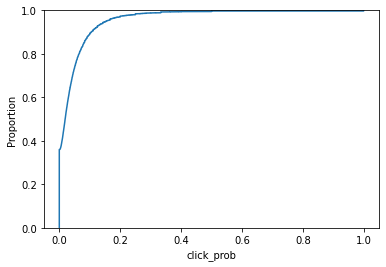

In [29]:
sns.ecdfplot(df_click["click_prob"])

## join news and click information

In [30]:
df_news.info(), df_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101527 entries, 0 to 101526
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 101527 non-null  object
 1   category           101527 non-null  object
 2   subcategory        101527 non-null  object
 3   title              101527 non-null  object
 4   abstract           96112 non-null   object
 5   url                101527 non-null  object
 6   title_entities     101524 non-null  object
 7   abstract_entities  101521 non-null  object
dtypes: object(8)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27046 entries, 0 to 27045
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          27046 non-null  object 
 1   click       27046 non-null  int64  
 2   non_click   27046 non-null  int64  
 3   click_prob  27046 non-null  float64
dtypes: float64(

(None, None)

In [31]:
print (df_news.count())
len(df_news["id"].unique())

id                   101527
category             101527
subcategory          101527
title                101527
abstract              96112
url                  101527
title_entities       101524
abstract_entities    101521
dtype: int64


101527

In [32]:
df_join = pd.merge(df_news, df_click, on="id", how='left')
df_join.count()

id                   101527
category             101527
subcategory          101527
title                101527
abstract              96112
url                  101527
title_entities       101524
abstract_entities    101521
click                 27046
non_click             27046
click_prob            27046
dtype: int64

In [33]:
df_join.head()

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By","Shop the notebooks, jackets, and more that the royals can't live without.",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"", ""Type"": ""P"", ""WikidataId"": ""Q80976"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [48], ""SurfaceForms"": [""Prince Philip""]}, {""Label"": ""Charles, Prince of Wales"", ""Type"": ""P"", ""WikidataId"": ""Q43274"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [28], ""SurfaceForms"": [""Prince Charles""]}, {""Label"": ""Elizabeth II"", ""Type"": ""P"", ""WikidataId"": ""Q9682"", ""Confidence"": 0.97, ""OccurrenceOffsets"": [11], ""SurfaceForms"": [""Queen Elizabeth""]}]",[],0.0,1.0,0.0
1,N45436,news,newsscienceandtechnology,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on last year's models.,https://assets.msn.com/labs/mind/AABmf2I.html,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ""Q2796"", ""Confidence"": 0.999, ""OccurrenceOffsets"": [42], ""SurfaceForms"": [""iPads""]}, {""Label"": ""Walmart"", ""Type"": ""O"", ""WikidataId"": ""Q483551"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [0], ""SurfaceForms"": [""Walmart""]}]","[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ""Q2796"", ""Confidence"": 0.999, ""OccurrenceOffsets"": [12], ""SurfaceForms"": [""iPad""]}, {""Label"": ""Apple Inc."", ""Type"": ""O"", ""WikidataId"": ""Q312"", ""Confidence"": 0.999, ""OccurrenceOffsets"": [0], ""SurfaceForms"": [""Apple""]}]",NaN,NaN,NaN
2,N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding you back and keeping you from shedding that unwanted belly fat for good.,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""WikidataId"": ""Q193583"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [20], ""SurfaceForms"": [""Belly Fat""]}]","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""WikidataId"": ""Q193583"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [97], ""SurfaceForms"": [""belly fat""]}]",NaN,NaN,NaN
3,N86255,health,medical,Dispose of unwanted prescription drugs during the DEA's Take Back Day,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ""Type"": ""O"", ""WikidataId"": ""Q622899"", ""Confidence"": 0.992, ""OccurrenceOffsets"": [50], ""SurfaceForms"": [""DEA""]}]",[],NaN,NaN,NaN
4,N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches of Ukraine's War,"Lt. Ivan Molchanets peeked over a parapet of sand bags at the front line of the war in Ukraine. Next to him was an empty helmet propped up to trick snipers, already perforated with multiple holes.",https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId"": ""Q212"", ""Confidence"": 0.946, ""OccurrenceOffsets"": [87], ""SurfaceForms"": [""Ukraine""]}]",NaN,NaN,NaN


## process categogies

In [34]:
# process data
df_join["click_prob"] = df_join["click_prob"].fillna(0)
df_join["click_prob_flag"] = np.where(df_join["click_prob"]>0.5, 1, 0)

In [35]:
from sklearn import preprocessing

df_join_all = df_join.copy()
lab_enc = preprocessing.LabelEncoder()
df_join_all["category_flag"] = lab_enc.fit_transform(df_join_all["category"])
display(df_join_all.head(2))

# save to csv file
filename = data_path + "news_click_df_all.csv"
df_join_all.to_csv(filename)

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By","Shop the notebooks, jackets, and more that the royals can't live without.",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"", ""Type"": ""P"", ""WikidataId"": ""Q80976"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [48], ""SurfaceForms"": [""Prince Philip""]}, {""Label"": ""Charles, Prince of Wales"", ""Type"": ""P"", ""WikidataId"": ""Q43274"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [28], ""SurfaceForms"": [""Prince Charles""]}, {""Label"": ""Elizabeth II"", ""Type"": ""P"", ""WikidataId"": ""Q9682"", ""Confidence"": 0.97, ""OccurrenceOffsets"": [11], ""SurfaceForms"": [""Queen Elizabeth""]}]",[],0.0,1.0,0.0,0,7
1,N45436,news,newsscienceandtechnology,Walmart Slashes Prices on Last-Generation iPads,Apple's new iPad releases bring big deals on last year's models.,https://assets.msn.com/labs/mind/AABmf2I.html,"[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ""Q2796"", ""Confidence"": 0.999, ""OccurrenceOffsets"": [42], ""SurfaceForms"": [""iPads""]}, {""Label"": ""Walmart"", ""Type"": ""O"", ""WikidataId"": ""Q483551"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [0], ""SurfaceForms"": [""Walmart""]}]","[{""Label"": ""IPad"", ""Type"": ""J"", ""WikidataId"": ""Q2796"", ""Confidence"": 0.999, ""OccurrenceOffsets"": [12], ""SurfaceForms"": [""iPad""]}, {""Label"": ""Apple Inc."", ""Type"": ""O"", ""WikidataId"": ""Q312"", ""Confidence"": 0.999, ""OccurrenceOffsets"": [0], ""SurfaceForms"": [""Apple""]}]",NaN,NaN,0.0,0,11


In [36]:
df_select = df_join.copy()
df_select = df_select[df_select["category"].isin(["sports","movies"])]
# df_select = df_select[df_select["category"].isin(["news","sports","movies"])]
lab_enc = preprocessing.LabelEncoder()
df_select["category_flag"] = lab_enc.fit_transform(df_select["category"])
display(df_select.head(2))

# save to csv file
filename = data_path + "news_click_df_select.csv"
df_select.to_csv(filename)

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag
8,N124534,sports,football_nfl,Should NFL be able to fine players for criticizing officiating?,Several fines came down against NFL players for criticizing officiating this week. It's a very bad look for the league.,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [7], ""SurfaceForms"": [""NFL""]}]","[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [32], ""SurfaceForms"": [""NFL""]}]",NaN,NaN,0.0,0,1
18,N107267,sports,football_nfl,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds","Good morning, Eagles fans. Is everybody OK? I know it's been a tough couple days for you all, first with the Eagles' rough 22-14 win over the Chicago Bears and then with the news that the team's most potent deep threat, DeSean Jackson, will likely be out for the season after reinjuring himself during the four snaps he played on Sunday. But hey, it's the bye week. So if you want to use this ...",https://assets.msn.com/labs/mind/AAJWD4e.html,"[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [3], ""SurfaceForms"": [""Eagles""]}]","[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [14, 109], ""SurfaceForms"": [""Eagles"", ""Eagles""]}, {""Label"": ""DeSean Jackson"", ""Type"": ""P"", ""WikidataId"": ""Q984336"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [220], ""SurfaceForms"": [""DeSean Jackson""]}, {""Label"": ""Chicago Bears"", ""Type"": ""O"", ""WikidataId"": ""Q205033"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [142], ""SurfaceForms"": [""Chicago Bears""]}]",NaN,NaN,0.0,0,1


# EDA: click flag

In [37]:
# load processed files
filename = data_path + "news_click_df_all.csv"
df_eda = pd.read_csv(filename)
# df_eda.head(1)
df_eda.count()

Unnamed: 0           101527
id                   101527
category             101527
subcategory          101527
title                101527
abstract              96112
url                  101527
title_entities       101524
abstract_entities    101521
click                 27046
non_click             27046
click_prob           101527
click_prob_flag      101527
category_flag        101527
dtype: int64

In [38]:
df_eda_click = df_eda.copy()
df_eda_click_count = df_eda[['category','click_prob_flag']].value_counts().reset_index()
df_eda_click_count = pd.pivot_table(df_eda_click_count, index="category", columns="click_prob_flag", values=0)
df_eda_click_count = df_eda_click_count.fillna(0)
df_eda_click_count["percent_click"] = df_eda_click_count[1] / (df_eda_click_count[0] + df_eda_click_count[1]) * 100
df_eda_click_count = df_eda_click_count.reset_index().sort_values('percent_click', ascending=False)
df_eda_click_count

click_prob_flag,category,0,1,percent_click
6,kids,103.0,1.0,0.961538
16,video,4563.0,6.0,0.131320
0,autos,3067.0,4.0,0.130251
9,movies,814.0,1.0,0.122699
1,entertainment,836.0,1.0,0.119474
3,foodanddrink,4413.0,5.0,0.113173
5,health,2926.0,3.0,0.102424
7,lifestyle,4566.0,4.0,0.087527
13,sports,31998.0,22.0,0.068707
14,travel,4952.0,3.0,0.060545


In [39]:
px.bar(data_frame=df_eda_click_count,x='category',y='percent_click')

In [40]:
df_eda_click_count.rename(columns={0: "non_click", 1: "click"}, inplace=True)
df_eda_click_count

click_prob_flag,category,non_click,click,percent_click
6,kids,103.0,1.0,0.961538
16,video,4563.0,6.0,0.131320
0,autos,3067.0,4.0,0.130251
9,movies,814.0,1.0,0.122699
1,entertainment,836.0,1.0,0.119474
3,foodanddrink,4413.0,5.0,0.113173
5,health,2926.0,3.0,0.102424
7,lifestyle,4566.0,4.0,0.087527
13,sports,31998.0,22.0,0.068707
14,travel,4952.0,3.0,0.060545


[Text(0.5, 0, '')]

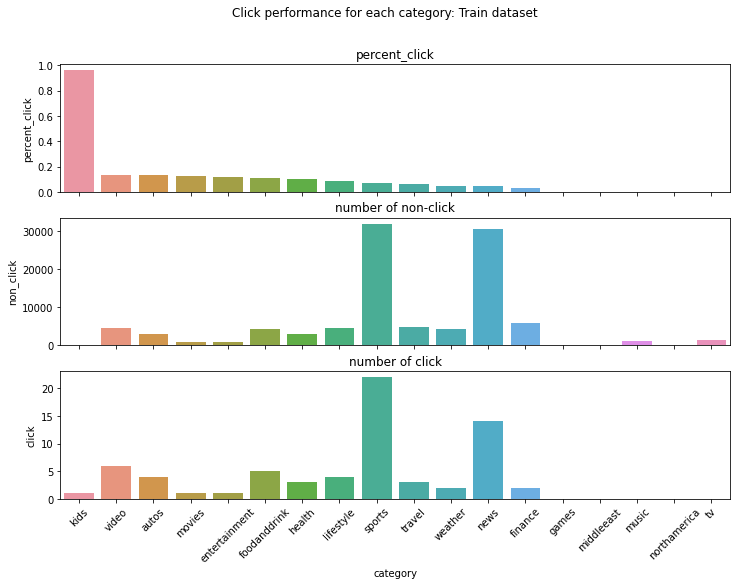

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Click performance for each category: Train dataset')

g1 = sns.barplot(ax=axes[0], data=df_eda_click_count,x='category',y='percent_click')
axes[0].set_title("percent_click")
g2 = sns.barplot(ax=axes[1], data=df_eda_click_count,x='category',y="non_click")
axes[1].set_title("number of non-click")

g3 = sns.barplot(ax=axes[2], data=df_eda_click_count,x='category',y="click")
axes[2].set_title("number of click")

plt.xticks(rotation=45)
g1.set(xlabel=None)
g2.set(xlabel=None)

In [42]:
df_eda_click = df_eda[df_eda['click_prob_flag']==1]
df_eda_click_count = df_eda_click[['category','subcategory']].value_counts()
print(df_eda_click_count.head())

category_index = []
for i in df_eda_click_count.index:
    category_index.append(np.array(i))
category_index = np.array(category_index)

df = pd.DataFrame(columns=['category','subcategory','values'])
df['category'] = category_index[:,0]
df['subcategory'] = category_index[:,1]
df['values'] = df_eda_click_count.values

px.bar(data_frame=df,x='category',y='values',color='subcategory')

category  subcategory  
sports    football_nfl     9
news      newsus           6
video     news             3
news      newspolitics     3
sports    football_ncaa    3
dtype: int64


In [43]:
df_eda_click = df_eda[df_eda['click_prob_flag']==1]
df_eda_click_count = df_eda_click[['category']].value_counts()
print(df_eda_click_count.head())

category_index = []
for i in df_eda_click_count.index:
    category_index.append(np.array(i))
category_index = np.array(category_index)

df = pd.DataFrame(columns=['category','values'])
df['category'] = category_index[:,0]
df['count_click'] = df_eda_click_count.values

px.bar(data_frame=df,x='category',y='count_click',color='category')

category    
sports          22
news            14
video            6
foodanddrink     5
lifestyle        4
dtype: int64


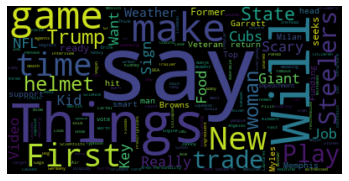

In [44]:
text=' '
for i in df_eda[df_eda['click_prob_flag']==1]['title']:
    text += i+' '

generate_word_cloud(text)

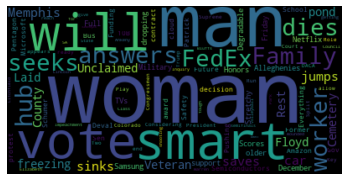

In [45]:
text=' '
for i in df_eda[(df_eda['click_prob_flag']==1) & (df_eda['category']=="news")]['title']:
    text += i+' '
generate_word_cloud(text)

# select and clean data: click_prob_flag

In [187]:
# train and validate (instead of test) datasets are used here.
data_path_train = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/"
data_path_test = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/"
filename_train = data_path_train + "news_click_df.csv"
filename_test = data_path_test + "news_click_df.csv"

In [188]:
from knowledge_distillation.data_process import DataProcessing

In [189]:
dp = DataProcessing()
# category_flag # click_prob_flag
data_df_train = dp.get_data(data_path_train, "title", "click_prob_flag")
data_df_test = dp.get_data(data_path_test, "title", "click_prob_flag")

0    32812
1       23
Name: click_prob_flag, dtype: int64
1    32020
0      815
Name: category_flag, dtype: int64


,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag,text,label
0,8,N124534,sports,football_nfl,Should NFL be able to fine players for criticizing officiating?,Several fines came down against NFL players for criticizing officiating this week. It's a very bad look for the league.,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [7], ""SurfaceForms"": [""NFL""]}]","[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [32], ""SurfaceForms"": [""NFL""]}]",NaN,NaN,0.0,0,1,Should NFL be able to fine players for criticizing officiating?,0
1,18,N107267,sports,football_nfl,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds","Good morning, Eagles fans. Is everybody OK? I know it's been a tough couple days for you all, first with the Eagles' rough 22-14 win over the Chicago Bears and then with the news that the team's most potent deep threat, DeSean Jackson, will likely be out for the season after reinjuring himself during the four snaps he played on Sunday. But hey, it's the bye week. So if you want to use this ...",https://assets.msn.com/labs/mind/AAJWD4e.html,"[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [3], ""SurfaceForms"": [""Eagles""]}]","[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [14, 109], ""SurfaceForms"": [""Eagles"", ""Eagles""]}, {""Label"": ""DeSean Jackson"", ""Type"": ""P"", ""WikidataId"": ""Q984336"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [220], ""SurfaceForms"": [""DeSean Jackson""]}, {""Label"": ""Chicago Bears"", ""Type"": ""O"", ""WikidataId"": ""Q205033"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [142], ""SurfaceForms"": [""Chicago Bears""]}]",NaN,NaN,0.0,0,1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",0


0    22252
1        4
Name: click_prob_flag, dtype: int64
1    21579
0      677
Name: category_flag, dtype: int64


,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag,text,label
0,7,N124534,sports,football_nfl,Should NFL be able to fine players for criticizing officiating?,Several fines came down against NFL players for criticizing officiating this week. It's a very bad look for the league.,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [7], ""SurfaceForms"": [""NFL""]}]","[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [32], ""SurfaceForms"": [""NFL""]}]",NaN,NaN,0.0,0,1,Should NFL be able to fine players for criticizing officiating?,0
1,18,N117551,sports,football_nfl,"Rye football wins 2019 rendition of The Game, clobbers Harrison","After going into halftime tied, the Garnets regrouped and made a resounding second-half statement in The Game.",https://assets.msn.com/labs/mind/AAIGv0N.html,[],[],NaN,NaN,0.0,0,1,"Rye football wins 2019 rendition of The Game, clobbers Harrison",0


In [190]:
select_col = ["text","label"]
num_classes = len(data_df_train["label"].unique())

select_data_df_train = dp.select_data(data_df_train, select_col, decrease_fold=1)
select_data_df_test = dp.select_data(data_df_test, select_col, decrease_fold=1)
select_data_df_train.head(2)

0    32812
1       23
Name: label, dtype: int64
0    22252
1        4
Name: label, dtype: int64


,text,label
0,Should NFL be able to fine players for criticizing officiating?,0
1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",0


In [191]:
select_data_df_train, select_data_df_test = dp.clean_data(select_data_df_train, select_data_df_test)

dp.save_data_to_csv(select_data_df_train, data_path_train, select_columns=["text_clean","label"])
dp.save_data_to_csv(select_data_df_test, data_path_test, select_columns=["text_clean","label"])

filename_ /content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/news_click_df.csv
0    32812
1       23
Name: label, dtype: int64
filename_ /content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/news_click_df.csv
0    22252
1        4
Name: label, dtype: int64


In [192]:
select_data_df_train.head()

,text,label,text_clean,text_len,text_word_count
0,Should NFL be able to fine players for criticizing officiating?,0,should nfl be able to fine players for criticizing officiating,62,10
1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",0,as eagles take their bye a look at how the defense has improved lately early birds,82,16
2,"Rye football wins 2019 rendition of The Game, clobbers Harrison",0,rye football wins rendition of the game clobbers harrison,57,9
3,"John Dorsey admits talks with Washington, but it ""takes two to tango""",0,john dorsey admits talks with washington but it takes two to tango,66,12
4,"Michigan finally shows some fight, but can't seal the deal",0,michigan finally shows some fight but cant seal the deal,56,10


In [193]:
select_data_df_train[["text_len","text_word_count"]].describe()

,text_len,text_word_count
count,32835.000000,32835.000000
mean,62.641632,10.308482
std,19.062207,3.306694
min,5.000000,1.000000
25%,50.000000,8.000000
50%,62.000000,10.000000
75%,74.000000,12.000000
max,238.000000,39.000000


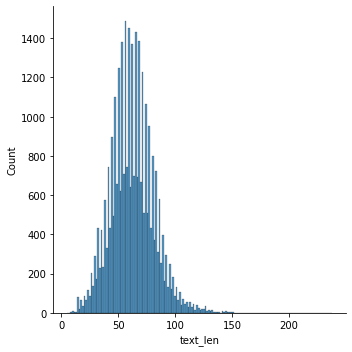

In [194]:
sns.displot(select_data_df_train['text_len'])

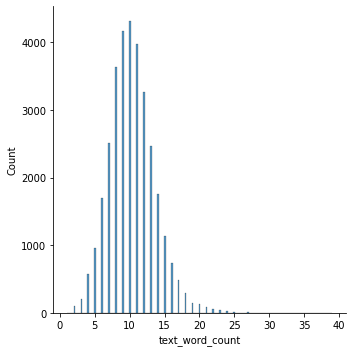

In [195]:
sns.displot(select_data_df_train['text_word_count'])

In [196]:
df_melt = pd.melt(select_data_df_train, value_vars=['text_len', 'text_word_count'],
                  var_name='text_characteristic', value_name='count')

# sns.displot(df_melt, hue="text_characteristic" )
# sns.displot(select_data_df_train['text_word_count'])
df_melt.head()

,text_characteristic,count
0,text_len,62
1,text_len,82
2,text_len,57
3,text_len,66
4,text_len,56


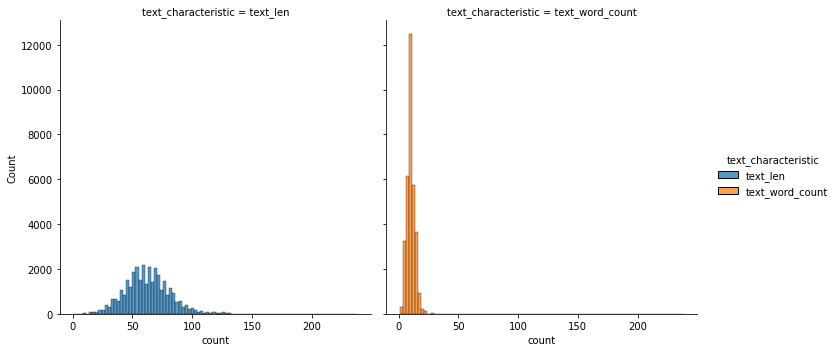

In [197]:
sns.displot(df_melt, x="count", hue="text_characteristic", col="text_characteristic")

In [198]:
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
# https://www.kaggle.com/parulpandey/eda-and-preprocessing-for-bert
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

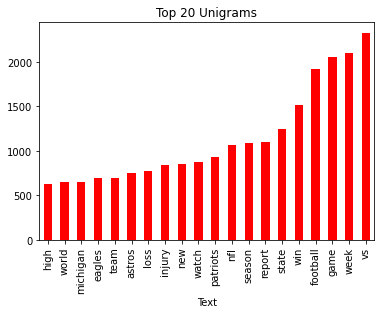

In [199]:
top_clean_text = get_top_n_words(select_data_df_train['text_clean'], 20)

df1 = pd.DataFrame(top_clean_text, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).plot(
    kind='bar', color='red', title='Top 20 Unigrams')

In [200]:
df1.groupby('Text').sum()['count'].sort_values(ascending=True).to_frame().reset_index().head()

,Text,count
0,high,630
1,world,644
2,michigan,649
3,eagles,689
4,team,692


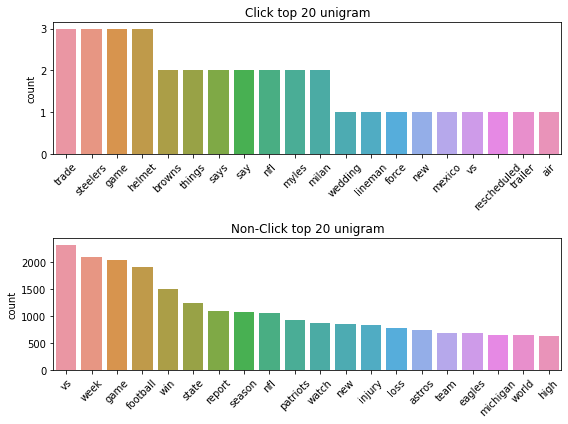

In [201]:
top_clean_text1 = get_top_n_words(select_data_df_train[select_data_df_train["label"]==1]['text_clean'], 20)
top_clean_text0 = get_top_n_words(select_data_df_train[select_data_df_train["label"]==0]['text_clean'], 20)

fig, axes = plt.subplots(2, 1, figsize=(8, 6))


df1 = pd.DataFrame(top_clean_text1, columns = ['Text' , 'count'])
g1 = sns.barplot(ax=axes[0], data=df1.groupby('Text').sum()['count'].sort_values(ascending=False).reset_index(),
                 x="Text", y="count")
axes[0].set_title("Click top 20 unigram")
# g1.set_ticklabels(rotation=45)
# axes[0].set_xlabel(rotation=45)
plt.xticks(rotation=90)

df0 = pd.DataFrame(top_clean_text0, columns = ['Text' , 'count'])
g2 = sns.barplot(ax=axes[1], data=df0.groupby('Text').sum()['count'].sort_values(ascending=False).reset_index(),
                 x="Text", y="count")
axes[1].set_title("Non-Click top 20 unigram")
g1.set(xlabel=None)
g2.set(xlabel=None)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.tight_layout()

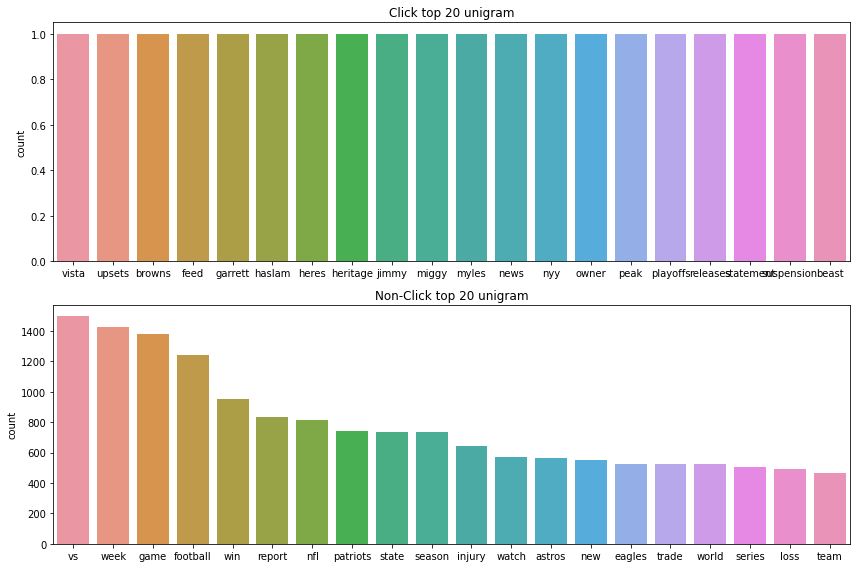

In [202]:
# test dataset
top_clean_text_test1 = get_top_n_words(select_data_df_test[select_data_df_test["label"]==1]['text_clean'], 20)
top_clean_text_test0 = get_top_n_words(select_data_df_test[select_data_df_test["label"]==0]['text_clean'], 20)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

dft1 = pd.DataFrame(top_clean_text_test1, columns = ['Text' , 'count'])
g1 = sns.barplot(ax=axes[0], data=dft1.groupby('Text').sum()['count'].sort_values(ascending=False).reset_index(),
                 x="Text", y="count")
axes[0].set_title("Click top 20 unigram")
# g1.set_ticklabels(rotation=45)
# axes[0].set_xlabel(rotat)

dft0 = pd.DataFrame(top_clean_text_test0, columns = ['Text' , 'count'])
g2 = sns.barplot(ax=axes[1], data=dft0.groupby('Text').sum()['count'].sort_values(ascending=False).reset_index(),
                 x="Text", y="count")
axes[1].set_title("Non-Click top 20 unigram")
g1.set(xlabel=None)
g2.set(xlabel=None)
plt.tight_layout()

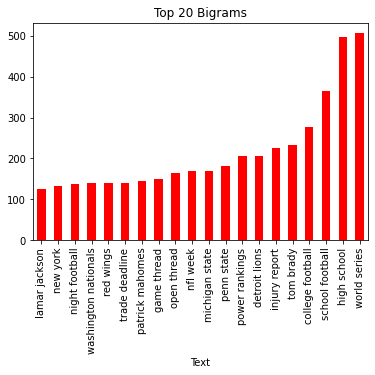

In [203]:
df_bigrams = get_top_n_gram(select_data_df_train['text_clean'],(2,2),20)

df_bigram1 = pd.DataFrame(df_bigrams, columns = ['Text' , 'count'])
df_bigram1.groupby('Text').sum()['count'].sort_values(ascending=True).plot(
    kind='bar', color='red', title='Top 20 Bigrams')

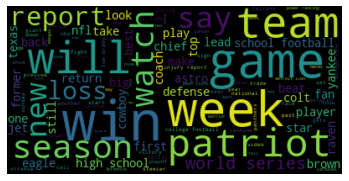

In [204]:
text=' '
for i in select_data_df_train['text_clean']:
    text += i+' '

generate_word_cloud(text)

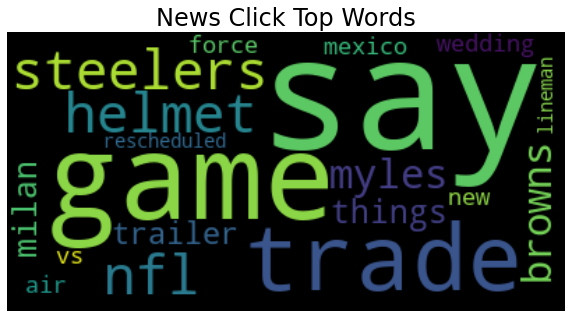

In [205]:
text=' '
for i in df1["Text"]:
    text += i+' '

fig, axes = plt.subplots(1, 1, figsize=(10, 8))
wordcloud = WordCloud().generate(text)
axes.imshow(wordcloud, interpolation="bilinear")
axes.axis("off")
axes.set_title("News Click Top Words", fontsize=24)
plt.show()

In [206]:
df1.head(3)

,Text,count
0,game,3
1,trade,3
2,steelers,3


Text(0.5, 1.0, 'Click top words')

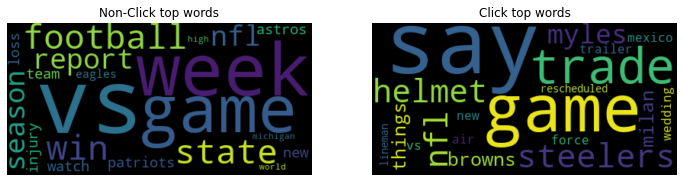

In [207]:
text_0=' '
for i in df0["Text"]:
    text_0 += i+' '

text_1=' '
for i in df1["Text"]:
    text_1 += i+' '


fig, axes = plt.subplots(1, 2, figsize=(12, 8))

wordcloud0 = WordCloud().generate(text_0)
axes[0].imshow(wordcloud0, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Non-Click top words")
wordcloud1 = WordCloud().generate(text_1)
axes[1].imshow(wordcloud1, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Click top words")

In [208]:
dft1.head()

,Text,count
0,nyy,1
1,news,1
2,miggy,1
3,myles,1
4,garrett,1


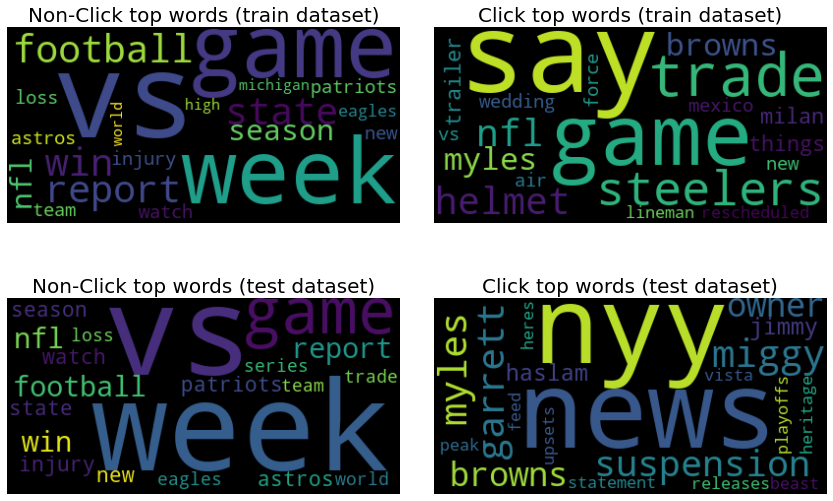

In [209]:
text_0=' '
for i in df0["Text"]:
    text_0 += i+' '

text_1=' '
for i in df1["Text"]:
    text_1 += i+' '

textt0=' '
for i in dft0["Text"]:
    textt0 += i+' '

textt1=' '
for i in dft1["Text"]:
    textt1 += i+' '


fig, axes = plt.subplots(2, 2, figsize=(12, 8))

wordcloud0 = WordCloud().generate(text_0)
axes[0,0].imshow(wordcloud0, interpolation="bilinear")
axes[0,0].axis("off")
axes[0,0].set_title("Non-Click top words (train dataset)", fontdict={'fontsize': 20})
wordcloud1 = WordCloud().generate(text_1)
axes[0,1].imshow(wordcloud1, interpolation="bilinear")
axes[0,1].axis("off")
axes[0,1].set_title("Click top words (train dataset)", fontdict={'fontsize': 20})

wordcloudt0 = WordCloud().generate(textt0)
axes[1,0].imshow(wordcloudt0, interpolation="bilinear")
axes[1,0].axis("off")
axes[1,0].set_title("Non-Click top words (test dataset)", fontdict={'fontsize': 20})
wordcloudt1 = WordCloud().generate(textt1)
axes[1,1].imshow(wordcloudt1, interpolation="bilinear")
axes[1,1].axis("off")
axes[1,1].set_title("Click top words (test dataset)", fontdict={'fontsize': 20})
plt.tight_layout()

# select and clean data: category_flag

In [210]:
dp = DataProcessing()
# category_flag # click_prob_flag
data_df_train = dp.get_data(data_path_train, "title", "category_flag")
data_df_test = dp.get_data(data_path_test, "title", "category_flag")

0    32812
1       23
Name: click_prob_flag, dtype: int64
1    32020
0      815
Name: category_flag, dtype: int64


,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag,text,label
0,8,N124534,sports,football_nfl,Should NFL be able to fine players for criticizing officiating?,Several fines came down against NFL players for criticizing officiating this week. It's a very bad look for the league.,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [7], ""SurfaceForms"": [""NFL""]}]","[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [32], ""SurfaceForms"": [""NFL""]}]",NaN,NaN,0.0,0,1,Should NFL be able to fine players for criticizing officiating?,1
1,18,N107267,sports,football_nfl,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds","Good morning, Eagles fans. Is everybody OK? I know it's been a tough couple days for you all, first with the Eagles' rough 22-14 win over the Chicago Bears and then with the news that the team's most potent deep threat, DeSean Jackson, will likely be out for the season after reinjuring himself during the four snaps he played on Sunday. But hey, it's the bye week. So if you want to use this ...",https://assets.msn.com/labs/mind/AAJWD4e.html,"[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [3], ""SurfaceForms"": [""Eagles""]}]","[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [14, 109], ""SurfaceForms"": [""Eagles"", ""Eagles""]}, {""Label"": ""DeSean Jackson"", ""Type"": ""P"", ""WikidataId"": ""Q984336"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [220], ""SurfaceForms"": [""DeSean Jackson""]}, {""Label"": ""Chicago Bears"", ""Type"": ""O"", ""WikidataId"": ""Q205033"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [142], ""SurfaceForms"": [""Chicago Bears""]}]",NaN,NaN,0.0,0,1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",1


0    22252
1        4
Name: click_prob_flag, dtype: int64
1    21579
0      677
Name: category_flag, dtype: int64


,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag,text,label
0,7,N124534,sports,football_nfl,Should NFL be able to fine players for criticizing officiating?,Several fines came down against NFL players for criticizing officiating this week. It's a very bad look for the league.,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [7], ""SurfaceForms"": [""NFL""]}]","[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [32], ""SurfaceForms"": [""NFL""]}]",NaN,NaN,0.0,0,1,Should NFL be able to fine players for criticizing officiating?,1
1,18,N117551,sports,football_nfl,"Rye football wins 2019 rendition of The Game, clobbers Harrison","After going into halftime tied, the Garnets regrouped and made a resounding second-half statement in The Game.",https://assets.msn.com/labs/mind/AAIGv0N.html,[],[],NaN,NaN,0.0,0,1,"Rye football wins 2019 rendition of The Game, clobbers Harrison",1


In [211]:
data_df_train["category_flag"].unique()
data_df_train[data_df_train["category_flag"]==0].head()

,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag,text,label
15,101,N110516,movies,movies-gallery,16 Live-Action Disney Movies in the Works After 'Maleficent: Mistress of Evil' (Photos),"The studio is raiding its vault to remake classics including ""Mulan""",https://assets.msn.com/labs/mind/AABDmxB.html,"[{""Label"": ""Maleficent: Mistress of Evil"", ""Type"": ""N"", ""WikidataId"": ""Q54437950"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [49], ""SurfaceForms"": [""Maleficent: Mistress of Evil""]}]","[{""Label"": ""Mulan (1998 film)"", ""Type"": ""W"", ""WikidataId"": ""Q537407"", ""Confidence"": 0.921, ""OccurrenceOffsets"": [62], ""SurfaceForms"": [""Mulan""]}]",NaN,NaN,0.0,0,0,16 Live-Action Disney Movies in the Works After 'Maleficent: Mistress of Evil' (Photos),0
28,174,N122668,movies,movies-gallery,Must-see biopics,Take a look at the greatest true-life biographical stories on the big screen.,https://assets.msn.com/labs/mind/AABsqwH.html,[],[],0.0,11.0,0.0,0,0,Must-see biopics,0
68,375,N51563,movies,movievideo,Trailer - One Last Night,Official Trailer,https://assets.msn.com/labs/mind/AAENK6D.html,[],[],0.0,1.0,0.0,0,0,Trailer - One Last Night,0
74,386,N113125,movies,movies-celebrity,The Fast and the Furious Director Rob Cohen Accused of Sexual Assault,A woman claims Cohen assaulted her in a hotel room while she was unconscious.,https://assets.msn.com/labs/mind/AAHZeOy.html,"[{""Label"": ""Rob Cohen"", ""Type"": ""P"", ""WikidataId"": ""Q503966"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [34], ""SurfaceForms"": [""Rob Cohen""]}, {""Label"": ""The Fast and the Furious (2001 film)"", ""Type"": ""W"", ""WikidataId"": ""Q155476"", ""Confidence"": 0.995, ""OccurrenceOffsets"": [0], ""SurfaceForms"": [""The Fast and the Furious""]}]","[{""Label"": ""Rob Cohen"", ""Type"": ""P"", ""WikidataId"": ""Q503966"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [15], ""SurfaceForms"": [""Cohen""]}]",NaN,NaN,0.0,0,0,The Fast and the Furious Director Rob Cohen Accused of Sexual Assault,0
84,427,N57553,movies,movies-celebrity,Celebrities at their Hollywood hand and footprint ceremonies,"See Kaley Cuoco, Melissa McCarthy, Keanu Reeves and more stars at their imprint ceremonies at the famed Chinese Theatre.",https://assets.msn.com/labs/mind/AACnQHE.html,[],"[{""Label"": ""Melissa McCarthy"", ""Type"": ""P"", ""WikidataId"": ""Q229048"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [17], ""SurfaceForms"": [""Melissa McCarthy""]}, {""Label"": ""Kaley Cuoco"", ""Type"": ""P"", ""WikidataId"": ""Q16759"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [4], ""SurfaceForms"": [""Kaley Cuoco""]}, {""Label"": ""Keanu Reeves"", ""Type"": ""P"", ""WikidataId"": ""Q43416"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [35], ""SurfaceForms"": [""Keanu Reeves""]}, {""Label"": ""TCL Chinese Theatre"", ""Type"": ""N"", ""WikidataId"": ""Q1122565"", ""Confidence"": 0.999, ""OccurrenceOffsets"": [104], ""SurfaceForms"": [""Chinese Theatre""]}]",NaN,NaN,0.0,0,0,Celebrities at their Hollywood hand and footprint ceremonies,0


In [212]:
select_col = ["text","label"]
num_classes = len(data_df_train["label"].unique())

select_data_df_train = dp.select_data(data_df_train, select_col, decrease_fold=1)
select_data_df_test = dp.select_data(data_df_test, select_col, decrease_fold=1)
select_data_df_train.head(2)

1    32020
0      815
Name: label, dtype: int64
1    21579
0      677
Name: label, dtype: int64


,text,label
0,Should NFL be able to fine players for criticizing officiating?,1
1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",1


In [213]:
select_data_df_train, select_data_df_test = dp.clean_data(select_data_df_train, select_data_df_test)

dp.save_data_to_csv(select_data_df_train, data_path_train, select_columns=["text_clean","label"])
dp.save_data_to_csv(select_data_df_test, data_path_test, select_columns=["text_clean","label"])

filename_ /content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/news_click_df.csv
1    32020
0      815
Name: label, dtype: int64
filename_ /content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/news_click_df.csv
1    21579
0      677
Name: label, dtype: int64


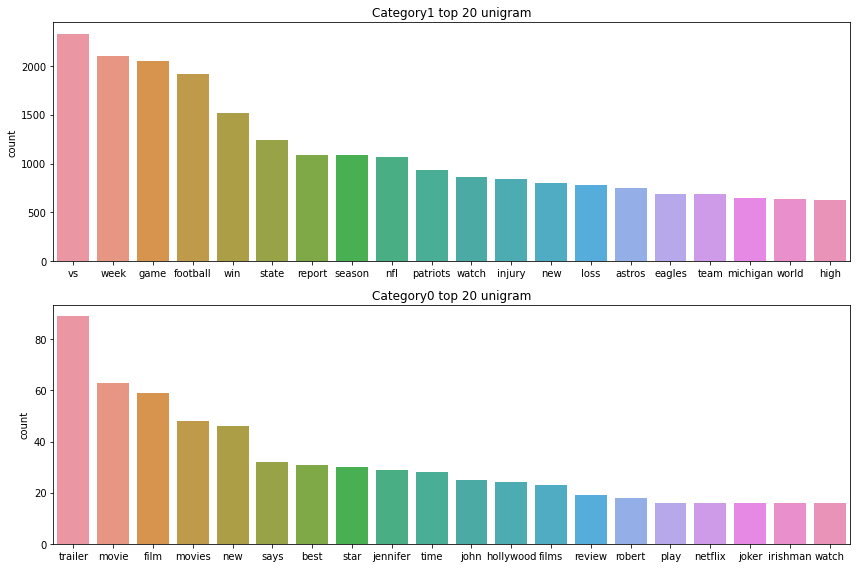

In [214]:
top_clean_text1c = get_top_n_words(select_data_df_train[select_data_df_train["label"]==1]['text_clean'], 20)
top_clean_text0c = get_top_n_words(select_data_df_train[select_data_df_train["label"]==0]['text_clean'], 20)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))


df1c = pd.DataFrame(top_clean_text1c, columns = ['Text' , 'count'])
g1 = sns.barplot(ax=axes[0], data=df1c.groupby('Text').sum()['count'].sort_values(ascending=False).reset_index(),
                 x="Text", y="count")
axes[0].set_title("Category1 top 20 unigram")

df0c = pd.DataFrame(top_clean_text0c, columns = ['Text' , 'count'])
g2 = sns.barplot(ax=axes[1], data=df0c.groupby('Text').sum()['count'].sort_values(ascending=False).reset_index(),
                 x="Text", y="count")
axes[1].set_title("Category0 top 20 unigram")
g1.set(xlabel=None)
g2.set(xlabel=None)
plt.tight_layout()

Text(0.5, 1.0, 'Sports Category Top Words')

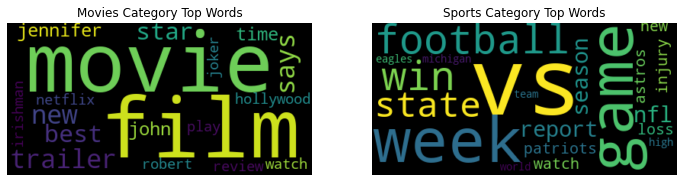

In [215]:
text_0=' '
for i in df0c["Text"]:
    text_0 += i+' '

text_1=' '
for i in df1c["Text"]:
    text_1 += i+' '


fig, axes = plt.subplots(1, 2, figsize=(12, 8))

wordcloud0 = WordCloud().generate(text_0)
axes[0].imshow(wordcloud0, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Movies Category Top Words")
wordcloud1 = WordCloud().generate(text_1)
axes[1].imshow(wordcloud1, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Sports Category Top Words")

# unmount and flush google drive

In [216]:
# from google.colab import drive
# drive.flush_and_unmount()